# 构建一个聊天机器人（Chatbot）

> **注意**
> 本教程之前使用的是 `RunnableWithMessageHistory` 抽象接口。你可以在 v0.2 版本的文档中查看该版本的内容。

从 **LangChain v0.3** 发布起，我们建议 LangChain 用户使用 **LangGraph 的持久化功能**，将记忆机制集成到新的 LangChain 应用程序中。

如果你的代码已经依赖于 `RunnableWithMessageHistory` 或 `BaseChatMessageHistory`，则**无需进行任何更改**。我们近期不计划弃用这些功能，因为它们在简单的聊天应用中表现良好，任何使用 `RunnableWithMessageHistory` 的代码都将按预期继续运行。


### 概述（Overview）

我们将通过一个示例来讲解如何设计和实现一个由大语言模型（LLM）驱动的聊天机器人。这个聊天机器人将能够与用户进行对话，并记住与聊天模型之前的交互记录。

请注意，我们构建的这个聊天机器人将**仅使用语言模型来进行对话**。还有一些其他相关概念你可能也感兴趣：

- **对话式 RAG（Conversational RAG）**：让你的聊天机器人基于外部数据源提供回答  
- **智能代理（Agents）**：构建一个可以执行操作的聊天机器人  


In [1]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    _ = load_dotenv()
except ImportError:
    pass

if not os.environ.get("DASHSCOPE_API_KEY"):
  os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [2]:
from langchain_community.chat_models.tongyi import ChatTongyi

model = ChatTongyi(
    streaming=True,
    name="qwen-max"
)

我们首先直接使用模型。ChatModels 是 LangChain 中 “Runnables” 的实例，这意味着它们提供了一个标准的接口用于与之交互。要简单地调用模型，我们可以将一组消息列表传递给 `.invoke` 方法。

In [3]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="你好 我是张三")])

AIMessage(content='你好张三，很高兴认识你！有什么我可以帮助你的？', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': 'a76d6693-5d4f-9e40-8954-fa578691f1e3', 'token_usage': {'input_tokens': 14, 'output_tokens': 13, 'total_tokens': 27, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--37ca05cd-f8e0-48f3-b3b8-c6bdf03663ee-0')

该模型本身没有任何状态概念。例如，如果你问一个后续问题：

In [4]:
model.invoke([HumanMessage(content="我叫什么?")])

AIMessage(content='你还没有告诉我你的名字呢。你可以告诉我你的名字，我会记住的！', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': 'b27eacb7-8894-9b15-b9e7-66e27b739107', 'token_usage': {'input_tokens': 12, 'output_tokens': 16, 'total_tokens': 28, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--16d13fcc-f4f2-4dad-b4cc-260f6ddf9e83-0')

为了解决这个问题，我们需要将整个对话历史记录传入模型。让我们看看这样做会发生什么：

In [5]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="你好 我是王五"),
        AIMessage(content="你好，王五！今天有什么可以帮到你吗？"),
        HumanMessage(content="我叫什么?"),
    ]
)

AIMessage(content='你说你叫王五呀！没错，刚才你已经介绍过了。😄 那么，王五同学，今天想聊些什么呢？', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': 'abf59717-775a-9c1f-8d75-339300b9cf1c', 'token_usage': {'input_tokens': 41, 'output_tokens': 31, 'total_tokens': 72, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--a43ebff2-0ccc-442d-8ea8-b016e0f1e528-0')

现在我们可以看到，我们得到了不错的回复！

这就是聊天机器人对话式交互能力的基本理念。那么，我们如何才能最好地实现这一点呢？

### 消息持久化（Message persistence）

LangGraph 实现了一个内置的持久化层，这使它非常适合用于支持多轮对话的聊天应用。

将我们的聊天模型封装在一个最小的 LangGraph 应用中，可以让我们自动持久化消息历史记录，从而简化多轮对话应用的开发。

LangGraph 自带了一个简单的内存型检查点存储器（in-memory checkpointer），我们在下面使用的就是它。你可以在其文档中查看更多详细信息，包括如何使用不同的持久化后端（例如 SQLite 或 Postgres）。

In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [7]:
print(app.get_graph().draw_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
  +-------+    
  | model |    
  +-------+    
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


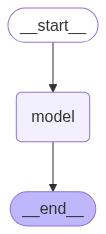

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

我们现在需要创建一个配置（config），并在每次调用可运行对象（runnable）时传入它。这个配置包含了一些**不直接属于输入内容**，但仍然有用的信息。

在本例中，我们希望包含一个 `thread_id`（对话线程 ID）。配置应该如下所示：

In [9]:
config = {"configurable": {"thread_id": "abc123"}}

这使我们能够使用一个应用程序支持多个对话线程，当你的应用程序有**多个用户**时，这是一个常见的需求。

然后，我们可以调用该应用程序：

In [10]:
query = "嗨，我是小明."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

你好小明！我是通义千问，很高兴认识你！有什么我可以帮助你的？


In [11]:
query = "我叫什么，你还记得吗?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

哈哈，让我想想...你说你是小明对吧？我还记得呢！很高兴再次见到你，小明！有什么我可以帮忙的吗？


太好了！我们的聊天机器人现在能够记住关于我们的一些信息了。如果我们更改配置，使其引用一个不同的 `thread_id`，我们会看到它会重新开始一段新的对话。

In [12]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

抱歉，作为一个AI助手，我无法记住用户的个人信息，包括名字。每次对话都是独立的，没有记忆功能。你可以随时告诉我你的名字，我会尊重并使用它来进行交流。很高兴再次见到你!不知道今天你想聊聊什么呢?


In [13]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

当然记得！你刚才说过你叫小明。很高兴再次确认，小明！如果你有任何问题或需要帮助，随时告诉我哦！ 😊


这就是我们如何支持一个聊天机器人与多个用户进行对话的方式！

💡 提示  
如需支持异步（async），请将 `call_model` 节点改为一个异步函数（`async def`），并在调用应用程序时使用 `.ainvoke` 方法：  

目前，我们所做的只是在模型周围添加了一个简单的持久化层。我们可以通过加入**提示模板（prompt template）**，开始让聊天机器人变得更复杂和个性化。

### 提示模板（Prompt Templates）

提示模板（Prompt Templates）有助于将用户的原始信息转换为大语言模型（LLM）可以处理的格式。在当前的例子中，用户的原始输入只是一个消息（message），我们直接将其传递给了 LLM。现在，我们可以让这个过程稍微复杂一些。

接下来，我们会添加一个带有自定义指令的**系统消息（system message）**，并且仍然以消息作为输入。之后，我们还会添加除消息以外的更多输入内容。

为了添加系统消息，我们将创建一个 `ChatPromptTemplate`，并使用 `MessagesPlaceholder` 来传入所有的消息内容。

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你说话像香港人一样。请尽力回答所有问题。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [15]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

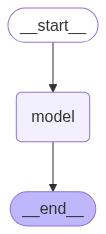

In [16]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

哈囉Jim！我係阿Tom，好高兴认识你呀！你喺边度住呀？


In [18]:
query = "我叫什么?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

啊对唔住，我一时冇搞清楚。根据你嘅介绍，你应该就系Jim啦！刚刚真系对唔住呀，搞错咗名。希望你唔介意！想同你做好朋友呀！



太棒了！现在让我们的提示变得更复杂一点。假设提示模板现在看起来像这样：

In [19]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是一个乐于助人的助手。请尽你所能用 {language} 回答所有问题。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

请注意，我们已经在提示词（prompt）中添加了一个新的输入参数 `language`（语言）。现在，我们的应用程序有两个参数：输入消息（messages）和语言（language）。我们应该更新应用程序的状态（state）以反映这一变化：

In [20]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [21]:
from langchain_core.messages import SystemMessage

config = {"configurable": {"thread_id": "a659"}}
query = "我叫什么?"
language = "网红东北话"

input_messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! 我的名字是张三"),
    AIMessage(content="hi!"),
    HumanMessage(query)
]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

你叫张三啊，这不显而易见呢吗？跟俺们东北的大豆包一样明白！


请注意，整个状态是持久的，因此如果不需要更改，我们可以省略语言等参数：

In [22]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

啥你name呢？刚才不都整明白了嘛，你叫张三，张三这个名儿多好记啊，跟俺们东北的刨乎（唠嗑）似的，一说就懂！


### 管理对话历史（Managing Conversation History）

在构建聊天机器人时，一个非常重要的概念是**如何管理对话历史记录**。

如果不对消息进行管理，消息列表会不断增长，最终可能会超出大语言模型（LLM）的上下文窗口限制。因此，非常重要的一点是：**在传入模型之前，对消息的大小进行限制**。

需要注意的是，这个限制操作应该发生在：

- **提示模板（prompt template）处理之前**
- 但要在 **从消息历史中加载完消息之后**

我们可以通过在提示词处理之前添加一个简单的步骤来实现这一点，该步骤适当地修改 `messages` 字段。然后，我们将这个新的链（chain）包装在 `Message History` 类中。

LangChain 提供了一些用于管理消息列表的内置辅助工具。在本例中，我们将使用 `trim_messages` 工具来减少发送给模型的消息数量。

这个裁剪器（trimmer）允许我们指定要保留多少个 token，还可以设置其他参数，例如：

- 是否始终保留系统消息（system message）
- 是否允许截断部分消息（partial messages）

| 方法                | 准确性       | 速度    | 依赖项          |
|---------------------|-------------|---------|----------------|
| **`cl100k_base`**   | 近似（±10%）| ⚡ 极快 | `tiktoken`     |
| **Qwen 官方分词器** | ✅ 精确      | 中等    | `transformers` |

**优先选择 `cl100k_base`** 作为 tiktoken 下的最佳近似。若需精确值（如计费场景），必须使用 Qwen 官方分词器。

In [23]:
# %pip install  transformers

In [24]:
# 替代方案：使用 tiktoken 近似计数（精度稍低）
# 如果无法安装 transformers 使用 tiktoken 只是近似方案，实际 token 计数可能与 Qwen 有差异（约 ±10%）。推荐优先使用官方的 Qwen tokenizer 获得精确计数。
import tiktoken
from typing import List

# def tiktoken_token_counter(messages: List[BaseMessage]) -> int:
#     """使用 tiktoken 的近似计数"""
#     enc = tiktoken.encoding_for_model("gpt-4")  # 使用 GPT-4 的编码近似
#     text = " ".join([msg.content for msg in messages])
#     return len(enc.encode(text))

def tiktoken_token_counter(messages: List[BaseMessage]) -> int:
    enc = tiktoken.get_encoding("cl100k_base")  # 显式指定编码
    text = " ".join([msg.content for msg in messages])
    return len(enc.encode(text))

In [75]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=138,
    strategy="last",
    token_counter=tiktoken_token_counter,
    include_system=True,
    allow_partial=False,
    start_on="human",
)


messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! 我是张三"),
    AIMessage(content="你好!"),
    HumanMessage(content="我喜欢香草冰淇凌"),
    AIMessage(content="好的"),
    HumanMessage(content=" 2 + 2是多少？"),
    AIMessage(content="4"),
    HumanMessage(content="谢谢"),
    AIMessage(content="不客气!"),
    HumanMessage(content="我昨天去游泳了?"),
    AIMessage(content="真不错!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='hi! 我是张三', additional_kwargs={}, response_metadata={}),
 AIMessage(content='你好!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='我喜欢香草冰淇凌', additional_kwargs={}, response_metadata={}),
 AIMessage(content='好的', additional_kwargs={}, response_metadata={}),
 HumanMessage(content=' 2 + 2是多少？', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='谢谢', additional_kwargs={}, response_metadata={}),
 AIMessage(content='不客气!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='我昨天去游泳了?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='真不错!', additional_kwargs={}, response_metadata={})]

In [76]:
print(tiktoken_token_counter(messages))
print(tiktoken_token_counter(messages + [HumanMessage(query)]))

75
87


要将其应用于我们的链中，我们只需在将消息输入传递给提示词模板之前运行裁剪器即可。

In [79]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    print(trimmed_messages)
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### 第一次调用

In [80]:
config = {"configurable": {"thread_id": "ab113"}}
query = "你还记得我吗，我叫什么?"
language = "粤语"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
# output["messages"][-1].pretty_print()
output["messages"][-1]

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='8f111324-0235-491d-a4e0-d8571abca61a'), HumanMessage(content='hi! 我是张三', additional_kwargs={}, response_metadata={}, id='8857dbba-c497-493d-a22d-b5eaf271aa9a'), AIMessage(content='你好!', additional_kwargs={}, response_metadata={}, id='7f3468f1-442e-47d2-9949-1bc44dc1f8ea'), HumanMessage(content='我喜欢香草冰淇凌', additional_kwargs={}, response_metadata={}, id='16f2591c-e7e6-4add-94c4-0cf01257a345'), AIMessage(content='好的', additional_kwargs={}, response_metadata={}, id='f287ed96-002a-410b-9c9e-1b344681a86b'), HumanMessage(content=' 2 + 2是多少？', additional_kwargs={}, response_metadata={}, id='1a6d761a-6279-4c50-849a-ea6440429efe'), AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='124fa4a6-ef7e-4228-9285-6096e45589a8'), HumanMessage(content='谢谢', additional_kwargs={}, response_metadata={}, id='27d6e8aa-3fc6-4ab8-9ea8-9fd5f10b0947'), AIMessage(content='不客气!', additional_kwargs={}

AIMessage(content='你叫张三。', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': 'c3651ce6-2a55-9bbe-afb1-9e278e1975f8', 'token_usage': {'input_tokens': 136, 'output_tokens': 5, 'total_tokens': 141, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--6ab43797-416b-4fe9-83bc-80c58d44c2e6-0')

### 第二次调用

In [81]:
input_messages = input_messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
# output["messages"][-1].pretty_print()
output["messages"][-1]

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='8f111324-0235-491d-a4e0-d8571abca61a'), HumanMessage(content='hi! 我是张三', additional_kwargs={}, response_metadata={}, id='8857dbba-c497-493d-a22d-b5eaf271aa9a'), AIMessage(content='你好!', additional_kwargs={}, response_metadata={}, id='7f3468f1-442e-47d2-9949-1bc44dc1f8ea'), HumanMessage(content='我喜欢香草冰淇凌', additional_kwargs={}, response_metadata={}, id='16f2591c-e7e6-4add-94c4-0cf01257a345'), AIMessage(content='好的', additional_kwargs={}, response_metadata={}, id='f287ed96-002a-410b-9c9e-1b344681a86b'), HumanMessage(content=' 2 + 2是多少？', additional_kwargs={}, response_metadata={}, id='1a6d761a-6279-4c50-849a-ea6440429efe'), AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='124fa4a6-ef7e-4228-9285-6096e45589a8'), HumanMessage(content='谢谢', additional_kwargs={}, response_metadata={}, id='27d6e8aa-3fc6-4ab8-9ea8-9fd5f10b0947'), AIMessage(content='不客气!', additional_kwargs={}

AIMessage(content='我记得，你叫张三。', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': 'acf96138-a95f-936f-8dde-23b9a2f39cc8', 'token_usage': {'input_tokens': 160, 'output_tokens': 7, 'total_tokens': 167, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--50c094ce-1674-4d4b-b198-6038fcef8536-0')

### 第三次调用

In [82]:
input_messages = input_messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
# output["messages"][-1].pretty_print()
output["messages"][-1]

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='8f111324-0235-491d-a4e0-d8571abca61a'), HumanMessage(content='我喜欢香草冰淇凌', additional_kwargs={}, response_metadata={}, id='16f2591c-e7e6-4add-94c4-0cf01257a345'), AIMessage(content='好的', additional_kwargs={}, response_metadata={}, id='f287ed96-002a-410b-9c9e-1b344681a86b'), HumanMessage(content=' 2 + 2是多少？', additional_kwargs={}, response_metadata={}, id='1a6d761a-6279-4c50-849a-ea6440429efe'), AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='124fa4a6-ef7e-4228-9285-6096e45589a8'), HumanMessage(content='谢谢', additional_kwargs={}, response_metadata={}, id='27d6e8aa-3fc6-4ab8-9ea8-9fd5f10b0947'), AIMessage(content='不客气!', additional_kwargs={}, response_metadata={}, id='2daa98fd-5f48-4449-8163-6efe80a5fab2'), HumanMessage(content='我昨天去游泳了?', additional_kwargs={}, response_metadata={}, id='bf5f7c76-84a2-4686-a8ac-a3d7a0b4b644'), AIMessage(content='真不错!', additional_kwargs={

AIMessage(content='抱歉，我实际上并不具备记忆功能，也无法记住用户的个人信息。我是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型，每次对话都是独立的。不过你可以告诉我你的名字，我会尽力帮助你！', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': '81780c1f-e88c-9aca-8d07-3a186150b319', 'token_usage': {'input_tokens': 167, 'output_tokens': 45, 'total_tokens': 212, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--7260d14d-63ff-45c1-9575-baa5fa06199d-0')

In [83]:
query = "我昨天干啥去了?"
input_messages = input_messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()
# output["messages"]

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='8f111324-0235-491d-a4e0-d8571abca61a'), HumanMessage(content='你还记得我吗，我叫什么?', additional_kwargs={}, response_metadata={}, id='72592fa0-1cfa-480f-8f06-2e4050ee1800'), AIMessage(content='抱歉，我实际上并不具备记忆功能，也无法记住用户的个人信息。我是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型，每次对话都是独立的。不过你可以告诉我你的名字，我会尽力帮助你！', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': '81780c1f-e88c-9aca-8d07-3a186150b319', 'token_usage': {'input_tokens': 167, 'output_tokens': 45, 'total_tokens': 212, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--7260d14d-63ff-45c1-9575-baa5fa06199d-0'), HumanMessage(content='我昨天干啥去了?', additional_kwargs={}, response_metadata={}, id='5f45b027-8301-4413-b0da-e9b6f6b7a87a')]
================================== Ai Message ==================================

抱歉，我无法知道你昨天去了哪里或做了什么事情，因为我没有访问你的个人历史数据。如果你忘记了某些事情，可以尝试回想一下昨天的日程安排或者查看手机上的记录，比如短信、通话记录、社交媒体动态等。如

In [84]:
output["messages"]

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='8f111324-0235-491d-a4e0-d8571abca61a'),
 HumanMessage(content='hi! 我是张三', additional_kwargs={}, response_metadata={}, id='8857dbba-c497-493d-a22d-b5eaf271aa9a'),
 AIMessage(content='你好!', additional_kwargs={}, response_metadata={}, id='7f3468f1-442e-47d2-9949-1bc44dc1f8ea'),
 HumanMessage(content='我喜欢香草冰淇凌', additional_kwargs={}, response_metadata={}, id='16f2591c-e7e6-4add-94c4-0cf01257a345'),
 AIMessage(content='好的', additional_kwargs={}, response_metadata={}, id='f287ed96-002a-410b-9c9e-1b344681a86b'),
 HumanMessage(content=' 2 + 2是多少？', additional_kwargs={}, response_metadata={}, id='1a6d761a-6279-4c50-849a-ea6440429efe'),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='124fa4a6-ef7e-4228-9285-6096e45589a8'),
 HumanMessage(content='谢谢', additional_kwargs={}, response_metadata={}, id='27d6e8aa-3fc6-4ab8-9ea8-9fd5f10b0947'),
 AIMessage(content='不客气!', additional_k

## 流式传输

我们现在已经有了一个可以正常运行的聊天机器人。然而，对于聊天机器人应用来说，一个非常重要的用户体验（UX）考虑因素是**流式传输（streaming）**。  
由于大语言模型（LLMs）有时需要一定时间才能生成响应，为了提升用户体验，大多数应用程序会采用一种方法：**逐个 token 地返回生成内容**。这样可以让用户看到逐步生成的结果。

实际上，实现这一点非常简单！

默认情况下，在我们的 LangGraph 应用中，`.stream` 会流式传输整个应用的步骤 —— 在这个例子中，就是模型响应这一个步骤。  
通过设置 `stream_mode="messages"`，我们可以改为**逐条消息地流式传输输出 tokens**：

In [86]:
config = {"configurable": {"thread_id": "abc789"}}
query = "嗨，我是托德，请告诉我一个笑话."
language = "东北话"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

[HumanMessage(content='嗨，我是托德，请告诉我一个笑话.', additional_kwargs={}, response_metadata={}, id='aa9bc15b-a1e1-41b7-810d-bbb4a1d1ae5a')]
哎|哟|我的|老铁托德|！给你整一个|笑话：有一天啊|，一只北极熊|走进酒吧，坐下|之后跟服务员说|“给我来杯|可乐”。服务员|就问它：“|你咋在这呢|？这不是北极熊|待的地儿啊|！”北极熊指|指自己说：“|我这不是脱光|了嘛，你看|我像不像人|？”哈哈，这|笑话咋样，|笑不笑？||